# Homework 4 – Applied ML


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model 
%matplotlib inline

## Question 1: Propensity score matching
### 1.1. A naive analysis
_Compare the distribution of the outcome variable (re78) between the two groups, using plots and numbers. To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization")._

_What might a naive "researcher" conclude from this superficial analysis?_

We first load the csv file and observe it.

In [24]:
data = pd.read_csv('lalonde.csv')
data = data.set_index(['id'])
data.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


We then separate the dataframe into two: one for participants of the training program, and one for those who were not part of it. We will then retrieve some statistics from that data such as mean, median, variance, some quantiles ...

In [25]:
data_treated = data[data.treat==1]
data_control = data[data.treat==0]

In [26]:
data_treated['re78'].describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

In [27]:
data_control['re78'].describe()

count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

/Users/brunebastide/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


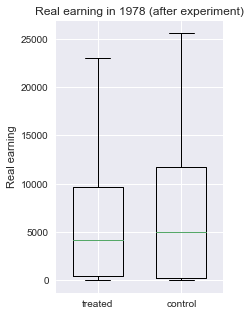

In [28]:
fig, ax = plt.subplots(1, figsize=(3, 5));
ax.boxplot([data_treated.re78, data_control.re78], widths=.6, showfliers=False);
ax.set_xticklabels(['treated', 'control']);
ax.set_ylabel('Real earning');
ax.set_title('Real earning in 1978 (after experiment)');

As surprinsing as it may be, we can see from our superficial approach that the person who were not trained have higher incomes in average (by comparing their medians) or by simply plotting them next to each other. Conclusions are difficult to be made as those results are very superficial. We also observe a much higher variance in the control group than in the treated one: the control group seems much more heterogeneous.

A naive researcher could also compare the salary increase/decrease before and after the experiment between the treated and non treated groups.

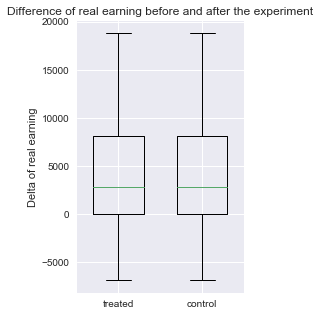

In [29]:
delta_treated = data_treated.re78 - data_treated.re75
delta_control = data_control.re78 - data_control.re75

fig, ax = plt.subplots(1, figsize=(3, 5));
ax.boxplot([delta_treated, delta_treated], widths=.6, showfliers=False);
ax.set_xticklabels(['treated', 'control']);
ax.set_ylabel('Delta of real earning');
ax.set_title('Difference of real earning before and after the experiment');

The distributions of incomes between the year 1978 and 1975 are similar in both groups. 

### 1.2. A closer look at the data

_You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above. You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions._

_For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers. As above, you may use the techniques we discussed in class for summarizing and comparing the distributions._

_What do you observe? Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis._

Eventhough ethnical statistics are very borderline: 2 = black, 1 = hisp, 0 = other (assume white).

In [30]:
data.loc[:,'race'] = 2*data.black + data.hispan
data.race = data.race.replace([0,1,2], ['white', 'hispan', 'black']).astype('category')
data.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,race
id,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,black
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,hispan
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,black
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,black
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,black


#### Married

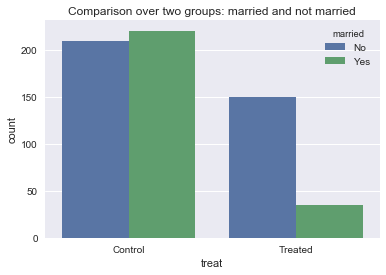

In [31]:
g = sns.countplot(x="treat", hue="married", data=data);

plt.xticks(plt.xticks()[0], ['Control', 'Treated']);
plt.title('Comparison over two groups: married and not married');
leg = g.axes.get_legend()
new_labels = ['No', 'Yes']
for t, l in zip(leg.texts, new_labels): t.set_text(l)
sns.plt.show()

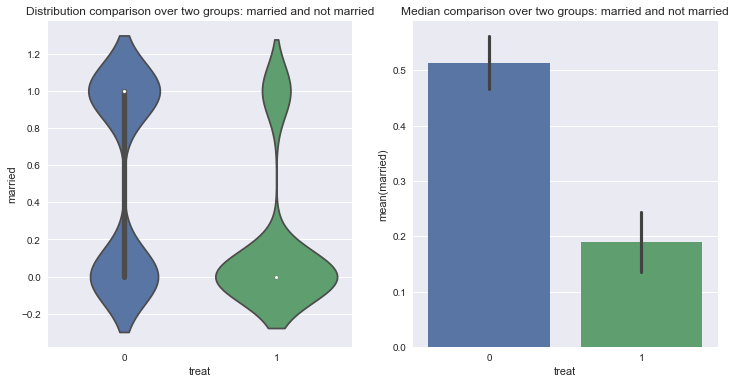

In [32]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

g1 = sns.violinplot(x = 'treat', y = 'married', data = data, ax = ax1);
g2 = sns.barplot(x = 'treat', y = 'married', data = data, ax = ax2);
ax1.set_title('Distribution comparison over two groups: married and not married');
ax2.set_title('Median comparison over two groups: married and not married');

There might have been a selection for the treated group: the control group seems homogeneous whereas the treated group has many more participants not married.

#### Race 

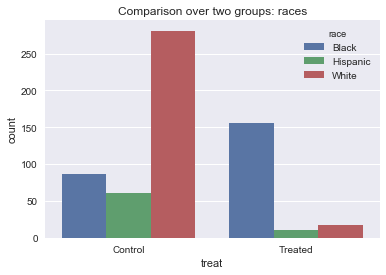

In [33]:
g = sns.countplot(x="treat", hue="race", data=data);
plt.xticks(plt.xticks()[0], ['Control', 'Treated']);
plt.title('Comparison over two groups: races');
leg = g.axes.get_legend()
new_labels = ['Black', 'Hispanic', 'White']
for t, l in zip(leg.texts, new_labels): t.set_text(l)
sns.plt.show()

White people do not seem to be favored to participate in the training program whereas Black people do, this is a social phenomenon of positive discrimination. 

#### Degree

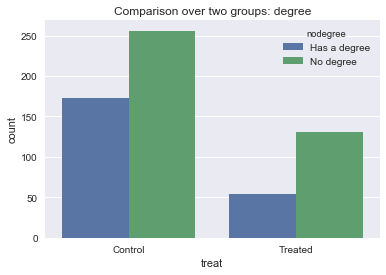

In [34]:
g = sns.countplot(x="treat", hue="nodegree", data=data);
plt.xticks(plt.xticks()[0], ['Control', 'Treated']);
plt.title('Comparison over two groups: degree');
leg = g.axes.get_legend()
new_labels = ['Has a degree', 'No degree']
for t, l in zip(leg.texts, new_labels): t.set_text(l)
sns.plt.show()

In general there are more participants selftaught than ones having degrees.

#### Education

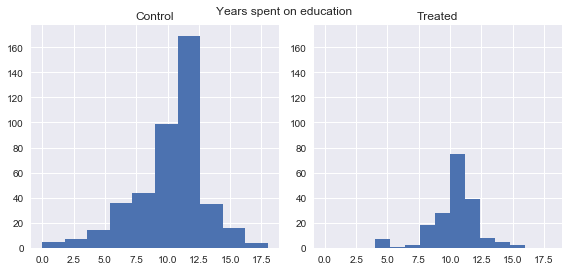

In [35]:
g = sns.FacetGrid(data = data, col = "treat", size = 4).map(plt.hist, "educ");
g.fig.suptitle('Years spent on education');
g.axes[0,0].set_xlabel('');
g.axes[0,1].set_xlabel('');
g.axes[0,0].set_title('Control');
g.axes[0,1].set_title('Treated');

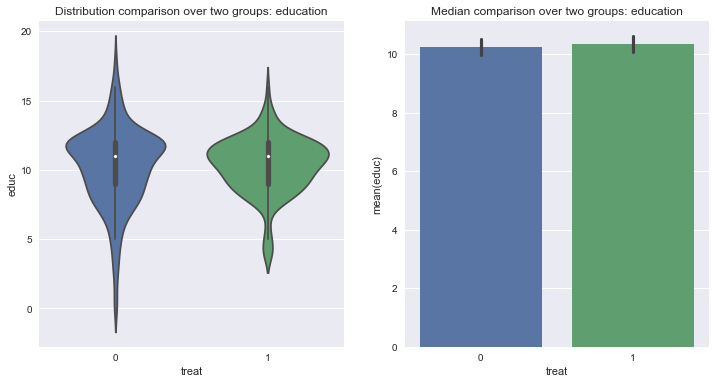

In [36]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

g1 = sns.violinplot(x = 'treat', y = 'educ', data = data, ax = ax1)
g2 = sns.barplot(x = 'treat', y = 'educ', data = data, ax = ax2)
ax1.set_title('Distribution comparison over two groups: education');
ax2.set_title('Median comparison over two groups: education');

It appears that in both cases (person belongs to either treated or control group), the education years are equivalently distributed, hence that would not be a selection criteria for the training program.

#### Age

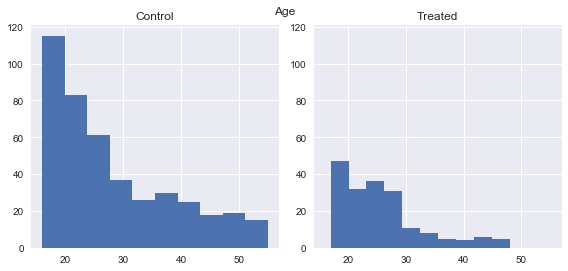

In [37]:
g_ = sns.FacetGrid(data = data, col = "treat", size = 4).map(plt.hist, "age");
g_.fig.suptitle('Age');
g_.axes[0,0].set_xlabel('');
g_.axes[0,1].set_xlabel('');
g_.axes[0,0].set_title('Control');
g_.axes[0,1].set_title('Treated');

We observe a same tendency in term of age distribution. Once again, the age might not be a selection criteria.

#### Real earning in 1975 and 1974

/Users/brunebastide/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


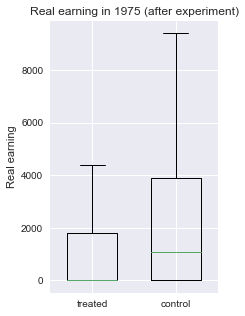

In [38]:
fig, ax = plt.subplots(1, figsize=(3, 5));
ax.boxplot([data_treated.re75, data_control.re75], widths=.6, showfliers=False);
ax.set_xticklabels(['treated', 'control']);
ax.set_ylabel('Real earning');
ax.set_title('Real earning in 1975 (after experiment)');

/Users/brunebastide/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


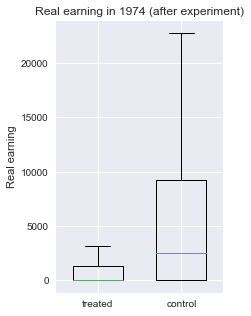

In [39]:
fig, ax = plt.subplots(1, figsize=(3, 5));
ax.boxplot([data_treated.re74, data_control.re74], widths=.6, showfliers=False);
ax.set_xticklabels(['treated', 'control']);
ax.set_ylabel('Real earning');
ax.set_title('Real earning in 1974 (after experiment)');

From both previous plots we observe that the treated group has an average income much lower than the control group: salary might be the first selection criteria for this experiment to belong to the treated group and the racial positive discrimination might then be a consequence of a societal problem: racial discrimination.

### 1.3 A propensity score model

_Use logistic regression to estimate propensity scores for all points in the dataset._

In [40]:
features = data.drop(['treat', 're78'], 1)
features.race = features.race.replace({'black': 2, 'hispan': 1, 'white': 0})

model = linear_model.LogisticRegression()
model.fit(features, data.treat)
pred = model.predict(features)

In [41]:
accuracy = sum(pred == data.treat) / len(data.treat)
print('accuracy: ', accuracy)

accuracy:  0.814332247557


## 4. Balancing the dataset via matching

### 4.1: Propensity Score Matching

First, the propensity scores are calculated and added to the dataframe

In [42]:
# Get propensity score
pscore = model.predict_proba(features)
data = data.assign(propensity_score = pscore[:,0])
data.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,race,propensity_score
id,,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,black,0.498733
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,hispan,0.722668
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,black,0.364549
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,black,0.344897
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,black,0.317592


The propensity scores are used to match each data point from the treated group with exactly one data point from the control group. To do that, we decided to use networkx package and work with DiGraph, which corresponds to directed graph with self loops.

In [43]:
import networkx as nx

G = nx.DiGraph()

# add a node for each sample
for i, row in data.iterrows():
    G.add_node(row.name, propensity=row['propensity_score'], treat=row['treat'])

# add an edge between treated control with propensity diff as weight
for n1, att1 in G.nodes(data=True):
    for n2, att2 in G.nodes(data=True):
        if att1['treat'] == 1 and att2['treat'] == 0:
            diff = abs(att1['propensity'] - att2['propensity'])
            G.add_edge(n1, n2, weight=1-diff)

matchings = nx.max_weight_matching(G)

Doublons are found for the matching. For example, 'NSW1'and 'PSID202' are matched twice:
- 1st match: 'NSW1': 'PSID202'
- 2nd match: 'PSID202': 'NSW1'

So we split the matching output to get only unique matches (185 in total, as it should).

In [44]:
true_matching = {}
for treat,no_treat in matchings.items():
    if treat[0:3] == 'PSI':
        true_matching[treat] = no_treat

We also check that each data point from the control group is matched with at most one data point from the treated group.
In other words, each data point from the control group can not be used more than once to match with the treated group.

In [45]:
if len(set(true_matching)) == len(data_treated) :
    print('Each data point from the control group is matched with at most one data point from the treated group')

Each data point from the control group is matched with at most one data point from the treated group


### 4.2: Comparison

The new matching is aplied to our dataset.

In [46]:
# Assign propensity score matching to the dataframe to keep only matched datapoints
data_treated = data.loc[[treat for no_treat,treat in true_matching.items()]]

In [47]:
# Assign propensity score matching to the dataframe to keep only matched datapoints
data_control = data.loc[[no_treat for no_treat,treat in true_matching.items()]]

With our new matching, there is the same number of data points between treated population and control population, knowing that the entire treated population is included.

To investigate the data, a boxplot of real earning (feature re78) for each group is plotted.

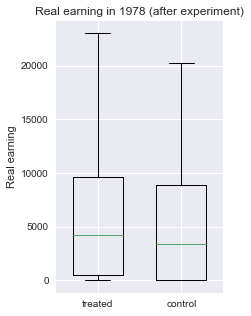

In [48]:
fig, ax = plt.subplots(1, figsize=(3, 5));
ax.boxplot([data_treated.re78, data_control.re78], widths=.6, showfliers=False);
ax.set_xticklabels(['treated', 'control']);
ax.set_ylabel('Real earning');
ax.set_title('Real earning in 1978 (after experiment)');

As opposed to our superficial approach, we can see that the people who were treated seem to have slightly higher outcomes by comparing their medians. We also observe a variance approximately equal in both groups.

We can also compare the salary increase/decrease before and after the experiment between the treated and non treated groups.

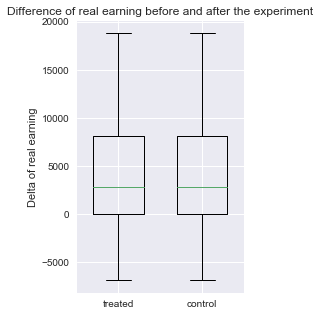

In [49]:
delta_treated = data_treated.re78 - data_treated.re75
delta_control = data_control.re78 - data_control.re75

fig, ax = plt.subplots(1, figsize=(3, 5));
ax.boxplot([delta_treated, delta_treated], widths=.6, showfliers=False);
ax.set_xticklabels(['treated', 'control']);
ax.set_ylabel('Delta of real earning');
ax.set_title('Difference of real earning before and after the experiment');

The boxplots is approximately similar between the two groups, showing that the difference of earning before and after the experiment is approximately equal for the two groups.

We compare again the feature-value distributions between the two groups, as in part 2 above, but now only for the matched subjects. The first feature shown is the marriage.

#### Married

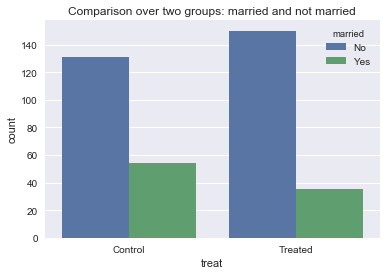

In [50]:
data_new = pd.concat([data_treated,data_control])

g = sns.countplot(x="treat", hue="married", data=data_new);
plt.xticks(plt.xticks()[0], ['Control', 'Treated']);
plt.title('Comparison over two groups: married and not married');
leg = g.axes.get_legend()
new_labels = ['No', 'Yes']
for t, l in zip(leg.texts, new_labels): t.set_text(l)
sns.plt.show()

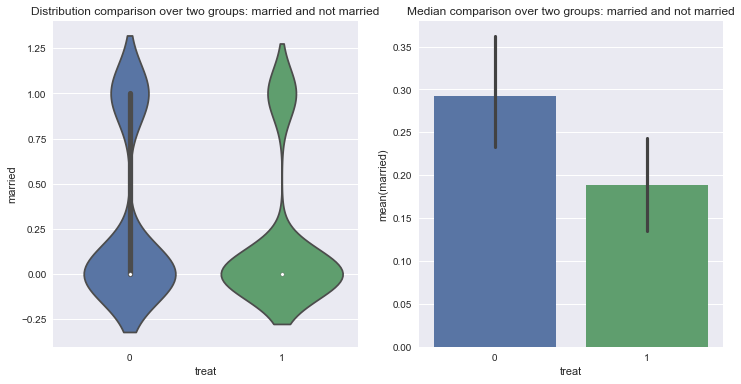

In [81]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

g1 = sns.violinplot(x = 'treat', y = 'married', data = data_new, ax = ax1);
g2 = sns.barplot(x = 'treat', y = 'married', data = data_new, ax = ax2);
ax1.set_title('Distribution comparison over two groups: married and not married');
ax2.set_title('Median comparison over two groups: married and not married');

The control group and the treated group seem to have similar distributions.

#### Degree

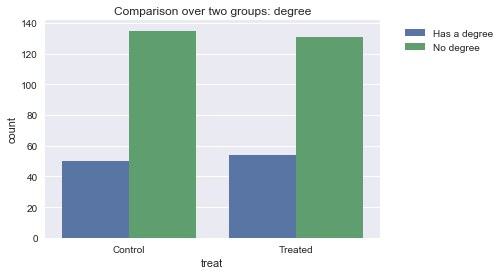

In [51]:
g = sns.countplot(x="treat", hue="nodegree", data=data_new);
plt.xticks(plt.xticks()[0], ['Control', 'Treated']);
plt.title('Comparison over two groups: degree');
plt.legend(bbox_to_anchor=(1.05, 1))
leg = g.axes.get_legend()
new_labels = ['Has a degree', 'No degree']
for t, l in zip(leg.texts, new_labels): t.set_text(l)
sns.plt.show()

In general there are more participants selftaught than ones having degrees.

#### Race

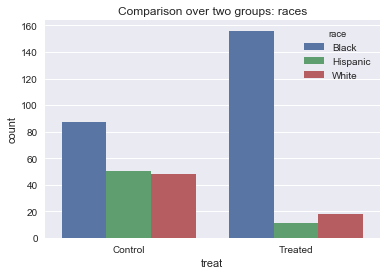

In [52]:
g = sns.countplot(x="treat", hue="race", data=data_new);
plt.xticks(plt.xticks()[0], ['Control', 'Treated']);
plt.title('Comparison over two groups: races');
leg = g.axes.get_legend()
new_labels = ['Black', 'Hispanic', 'White']
for t, l in zip(leg.texts, new_labels): t.set_text(l)
sns.plt.show()

White and hispanic people do not seem to be favored to participate in the training program whereas Black people do, this is a social phenomenon of positive discrimination. The race distribution between the treated group and the control group are really different.

#### Education

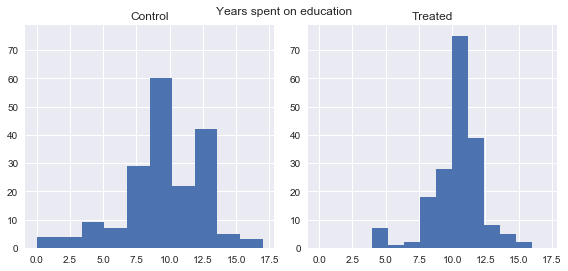

In [53]:
g = sns.FacetGrid(data = data_new, col = "treat", size = 4).map(plt.hist, "educ");
g.fig.suptitle('Years spent on education');
g.axes[0,0].set_xlabel('');
g.axes[0,1].set_xlabel('');
g.axes[0,0].set_title('Control');
g.axes[0,1].set_title('Treated');

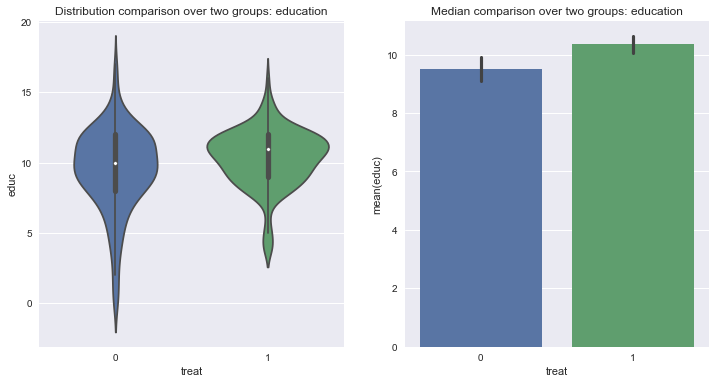

In [82]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

g1 = sns.violinplot(x = 'treat', y = 'educ', data = data_new, ax = ax1)
g2 = sns.barplot(x = 'treat', y = 'educ', data = data_new, ax = ax2)
ax1.set_title('Distribution comparison over two groups: education');
ax2.set_title('Median comparison over two groups: education');

It appears that in both cases (person belongs to either treated or control group), the education years are equivalently distributed, hence that would not be a selection criteria for the training program.

#### Age

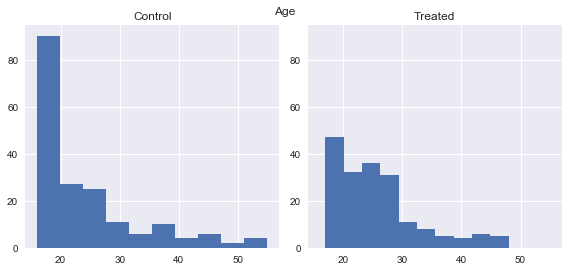

In [54]:
g_ = sns.FacetGrid(data = data_new, col = "treat", size = 4).map(plt.hist, "age");
g_.fig.suptitle('Age');
g_.axes[0,0].set_xlabel('');
g_.axes[0,1].set_xlabel('');
g_.axes[0,0].set_title('Control');
g_.axes[0,1].set_title('Treated');

We observe a same tendency in term of age distribution. Once again, the age might not be a selection criteria.

#### Real earning in 1975 and 1974

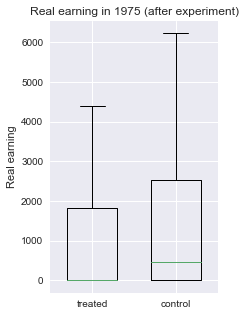

In [55]:
fig, ax = plt.subplots(1, figsize=(3, 5));
ax.boxplot([data_treated.re75, data_control.re75], widths=.6, showfliers=False);
ax.set_xticklabels(['treated', 'control']);
ax.set_ylabel('Real earning');
ax.set_title('Real earning in 1975 (after experiment)');

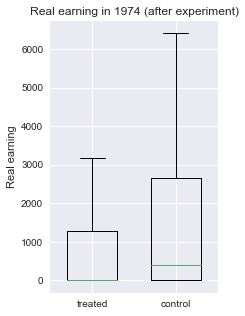

In [56]:
fig, ax = plt.subplots(1, figsize=(3, 5));
ax.boxplot([data_treated.re74, data_control.re74], widths=.6, showfliers=False);
ax.set_xticklabels(['treated', 'control']);
ax.set_ylabel('Real earning');
ax.set_title('Real earning in 1974 (after experiment)');

From both previous plots we observe that the treated group has an average income much lower than the control group: salary might be the first selection criteria for this experiment to belong to the treated group and the racial positive discrimination might then be a consequence of a societal problem: racial discrimination.

## 5: Comparison

_Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching? Would you say your dataset is sufficiently balanced? If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?_

_Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature. Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4._


Based on our comparison of feature-value distributions from part 4, we see that features are approximately balanced between the treated group and the control group, except for the "race" feature. 
Thus, to improve our matching, we decided to match only subjects that have the same value for the problematic feature, meaning that we match subjects that belong to the same "race".

As before, the propensity scores are used to match data points and networkx was applied again with DiGraph.

In [57]:
import networkx as nx

G = nx.DiGraph()

# add a node for each sample
for i, row in data.iterrows():
    G.add_node(row.name, propensity=row['propensity_score'], treat=row['treat'], race=row['race'])

# add an edge between treated control with propensity diff as weight
for n1, att1 in G.nodes(data=True):
    for n2, att2 in G.nodes(data=True):
        if att1['treat'] == 1 and att2['treat'] == 0 and att2['race'] == att1['race']:
            diff = abs(att1['propensity'] - att2['propensity'])
            G.add_edge(n1, n2, weight=1-diff)

matchings_2 = nx.max_weight_matching(G)

Doublons are found for the matching. For example, 'NSW1'and 'PSI97' are matched twice:
- 1st match: 'NSW1': 'PSID97'
- 2nd match: 'PSID97': 'NSW1'

So we split the matching output to get only unique matches (116 matches).

In [58]:
true_matching_2 = {}
for treat,no_treat in matchings_2.items():
    if treat[0:3] == 'PSI':
        true_matching_2[treat] = no_treat

This time, as the "race" condition was added to improve balance between the groups, only 116 datapoints from the treated group are matched with 116 datapoints from the control group. 

The new matching is applied to our dataset.

In [59]:
# Assign propensity score matching to the dataframe to keep only matched datapoints
data_treated = data.loc[[treat for no_treat,treat in true_matching_2.items()]]

In [60]:
# Assign propensity score matching to the dataframe to keep only matched datapoints
data_control = data.loc[[no_treat for no_treat,treat in true_matching_2.items()]]

With our new matching, there is the same number of data points between treated population and control population, that is 116.

## 6. A less naive analysis

Using our new balanced matching, we compare the outcomes (re78) between treated and control subjects, as we've done in part 1.

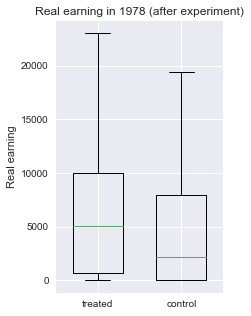

In [61]:
fig, ax = plt.subplots(1, figsize=(3, 5));
ax.boxplot([data_treated.re78, data_control.re78], widths=.6, showfliers=False);
ax.set_xticklabels(['treated', 'control']);
ax.set_ylabel('Real earning');
ax.set_title('Real earning in 1978 (after experiment)');

Considering our new matching, we see that the median of outcomes is higher for the treated group, suggesting the effectiveness of the job training program, as it allows to get higher outcomes.
This conclusion is opposite to the one we found before matching, doing a superficial analysis. 

It could also be interesting to investigate the mean difference of real earning (re78) between the two groups.
To do that, we decided to perform an independant 2 sample t-test to test if, wether or not, the difference in earning is significant between the groups. So our hypothesis are:
- Ho: There is no difference between the two means: mean_treated(re78) = mean_control(re78)
- Ha: There is a difference between the two means: mean_treated(re78) != mean_control(re78)

In [62]:
from scipy import stats
t, p = stats.ttest_ind(data_treated.re78, data_control.re78)

if p<0.05:
    print( 'p = %f --> The independant 2 sample student t-test does reject the null Hypothesis' %p)

p = 0.046835 --> The independant 2 sample student t-test does reject the null Hypothesis


The student t-test gives a p-value lower than 0.05, and confirms our assumption of the effectiveness of the job training program.


This analysis shows that for observational studies, when the dataset across treatment groups is not balanced, it is important to find a way to balance the dataset to make proper conclusions.

# Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

2. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.

---

In [63]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Data processing

In [64]:
newsgroups = fetch_20newsgroups()

We use the english stop words to remove the most common English words like "the", "at", "to", ...

In [65]:
# create a TF IDF module and fit it to the whole dataset
tf_idf = TfidfVectorizer(stop_words="english")
tf_idf.fit(newsgroups.data);

In [66]:
# add target name
target_names = np.array(newsgroups.target_names)
newsgroups.target = target_names[newsgroups.target]

We use stratified sampling to keep the same proportion of labels in the train, test and eval datasets. Note that we don't split the dataset between test and eval (10%-10%) because we will use tri-fold cross validation for the grid search instead of testing against the test set.

In [67]:
# split data stratified 0.8 train / 0.1 test / 0.1 eval

train_data, eval_data, train_target, eval_target = train_test_split(newsgroups.data, 
                                                                    newsgroups.target, 
                                                                    train_size=0.8, 
                                                                    test_size=0.2, 
                                                                    stratify=newsgroups.target)

# NOT USED FOR REASON ABOVE.
# test_data, eval_data, test_target, eval_target = train_test_split(other_data, 
#                                                                   other_target, 
#                                                                   train_size=0.5, 
#                                                                   test_size=0.5, 
#                                                                   stratify=other_target)

## Random forest classifier

In [68]:
# create random forest and put it in a pipeline with the TF IDF module
random_forest = RandomForestClassifier()
pipeline = Pipeline([('tf_idf', tf_idf), 
                     ('random_forest', random_forest)])
pipeline.fit(train_data, train_target);

# check that accuracy on train dataset is very high
pipeline.score(train_data, train_target)

0.9971273892387581

In [69]:
eval_pred = pipeline.predict(eval_data)
pipeline.score(eval_data, eval_target)

0.74812196199734871

We will do later a grid search to find some better parameters. But let's look at the confusion matrix of the current classifier.

/Users/brunebastide/anaconda/lib/python3.6/site-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/Users/brunebastide/anaconda/lib/python3.6/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


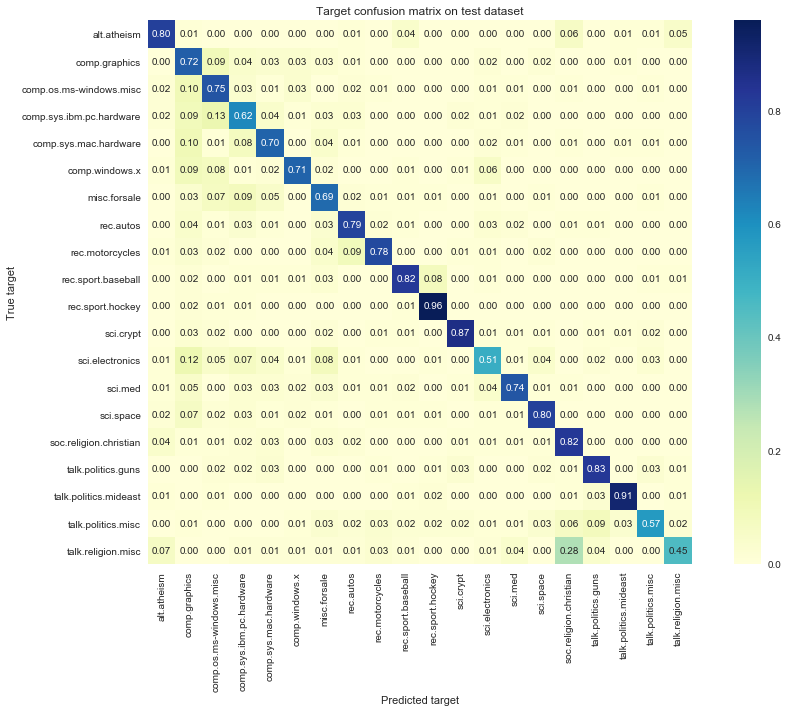

In [70]:
def confusion_matrix_plot(target_true, target_pred):
    confusion_m = confusion_matrix(target_true, target_pred, labels=newsgroups.target_names)
    confusion_m = confusion_m / confusion_m.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(1, figsize=(15,10))
    sns.heatmap(confusion_m, annot=True, ax=ax, square=True, 
               xticklabels=target_names, yticklabels=target_names,
               fmt='.2f', cmap="YlGnBu");
    ax.set_title('Target confusion matrix on test dataset');
    ax.set_ylabel('True target')
    ax.set_xlabel('Predicted target')

confusion_matrix_plot(eval_target, eval_pred)

We can do much better with some more training and some parameters tunning.

## Parameter tunning

In [71]:
from sklearn.model_selection import GridSearchCV

In [72]:
search_space = {
    'random_forest__n_estimators': [5, 20, 100, 1000],
    'random_forest__max_depth': [5, 20, 100]
}

grid_search = GridSearchCV(pipeline, param_grid=search_space, verbose=1, n_jobs=8)

In [73]:
grid_search.fit(X=train_data, y=train_target)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=8)]: Done  36 out of  36 | elapsed:  4.2min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('tf_idf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=8,
       param_grid={'random_forest__n_estimators': [5, 20, 100, 1000], 'random_forest__max_depth': [5, 20, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [74]:
classifier = grid_search.best_estimator_
grid_search.best_params_

{'random_forest__max_depth': 100, 'random_forest__n_estimators': 1000}

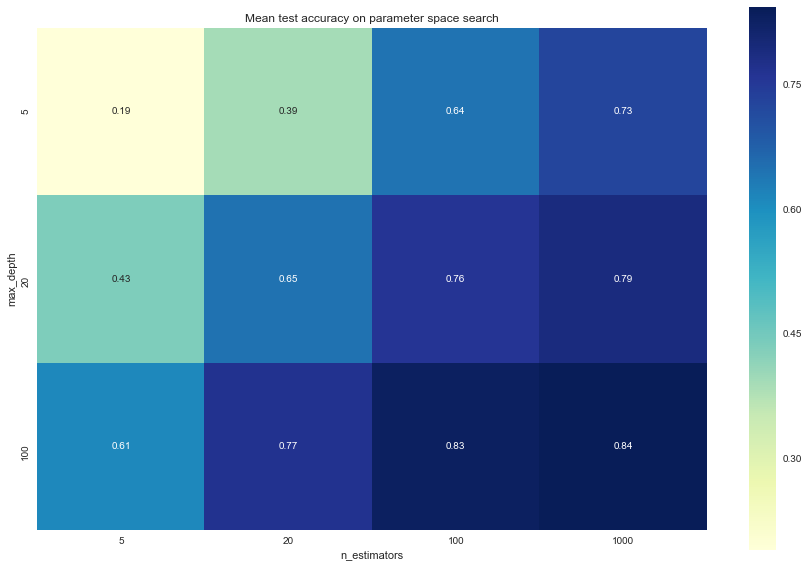

In [75]:
mean_test_grid = grid_search.cv_results_['mean_test_score'].reshape((
    len(search_space['random_forest__max_depth']),
    len(search_space['random_forest__n_estimators'])))

fig, ax = plt.subplots(1, figsize=(15,10))
sns.heatmap(mean_test_grid, annot=True, ax=ax, square=True, 
           xticklabels=search_space['random_forest__n_estimators'], 
           yticklabels=search_space['random_forest__max_depth'],
           fmt='.2f', cmap="YlGnBu");
ax.set_title('Mean test accuracy on parameter space search');
ax.set_xlabel('n_estimators');
ax.set_ylabel('max_depth');

The classifier has been retrained with the best parameters on the whole train dataset. Let's look at the accuracy on the evaluation dataset (20% of the total dataset). From our grid search, the best parameters are `max_depth = 100` and `n_estimators = 1000` but it seems that we could go further by exploring even more powerful models because we are not overfitting. But given that we might want to interpret the fitted model, it is more and more complicated.

In [76]:
classifier.score(eval_data, eval_target)

0.86168802474591255

Note that our classifier is very good on the eval data, that it has never seen during the training. It has not overfit. We are a bit higher than the mean training accuracy of the grid search (0.84) because we retrained on the whole training set (80%) of the data instead of the cross fold (~50% of the data).

Let's look at the confusion matrix of our classifier.

/Users/brunebastide/anaconda/lib/python3.6/site-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/Users/brunebastide/anaconda/lib/python3.6/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


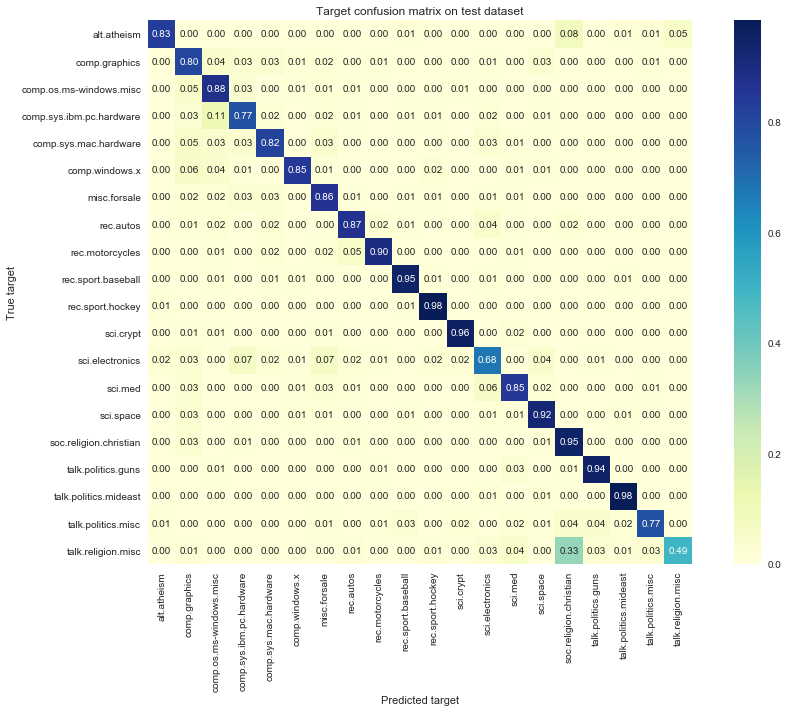

In [77]:
eval_pred = classifier.predict(eval_data)
confusion_matrix_plot(eval_target, eval_pred)

## Interpretation

In [78]:
import pandas as pd

classifier = pipeline
random_forest = classifier.steps[1][1]
tf_idf = classifier.steps[0][1]
importances = random_forest.feature_importances_
std_importances = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)
vocabulary = [w for w, _ in sorted(tf_idf.vocabulary_.items(), key=lambda x: x[1])]

feature_importances = pd.DataFrame({
    'word': vocabulary, 
    'mean': importances, 
    'std': std_importances})

feature_importances = feature_importances.sort_values(by='mean', ascending=False)

In [79]:
top_k = 20
display_top = feature_importances.head(20)
display_top

,mean,std,word
86483,0.006224,0.005962,sale
52797,0.005633,0.005503,hockey
30680,0.005128,0.004699,car
64838,0.004932,0.003951,mac
26846,0.004928,0.006287,bike
57014,0.004810,0.006816,israel
25717,0.004635,0.004920,baseball
103475,0.004371,0.004954,windows
33036,0.004128,0.004174,clipper
49888,0.003851,0.002721,graphics


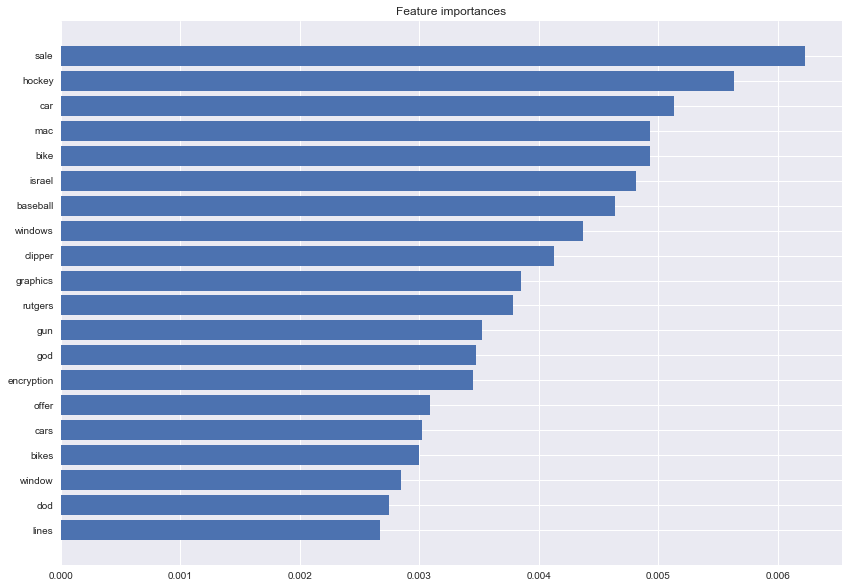

In [80]:
plt.figure(figsize=(14,10))
plt.title("Feature importances")
plt.barh(range(top_k), 
        display_top['mean'], 
        align="center")
plt.yticks(range(top_k), display_top['word'])
# plt.xlim([-1, top_k])
plt.gca().invert_yaxis()
plt.show()

We can see that some very meaningful words come out of this analysis. For instance bible is an important feature to decide between religion and christianism classes. Space is a meaningful keyword for the science space category.